### 아래 모델 각각에 최소 10가지 Categorical Feature Encoding 기법을 적용하여 성능을 비교 분석하시오.

#### Categorical Feature 유형(binary features, low- and high-cardinality nominal features, low- and high-cardinality ordinal features, cyclical features)별로 적합한 Categorical Feature Encoding이 있는가?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import mglearn
from sklearn.neural_network import MLPClassifier
import category_encoders as ce

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

## EDA

<AxesSubplot:xlabel='target', ylabel='count'>

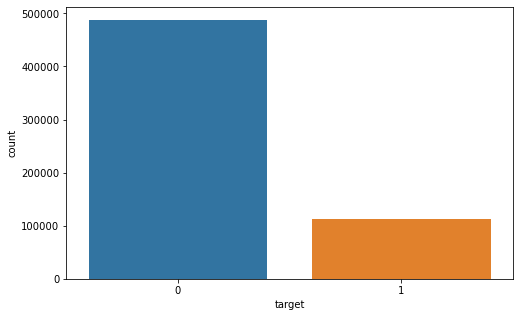

In [3]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
sns.countplot(train_df['target'], ax = ax)

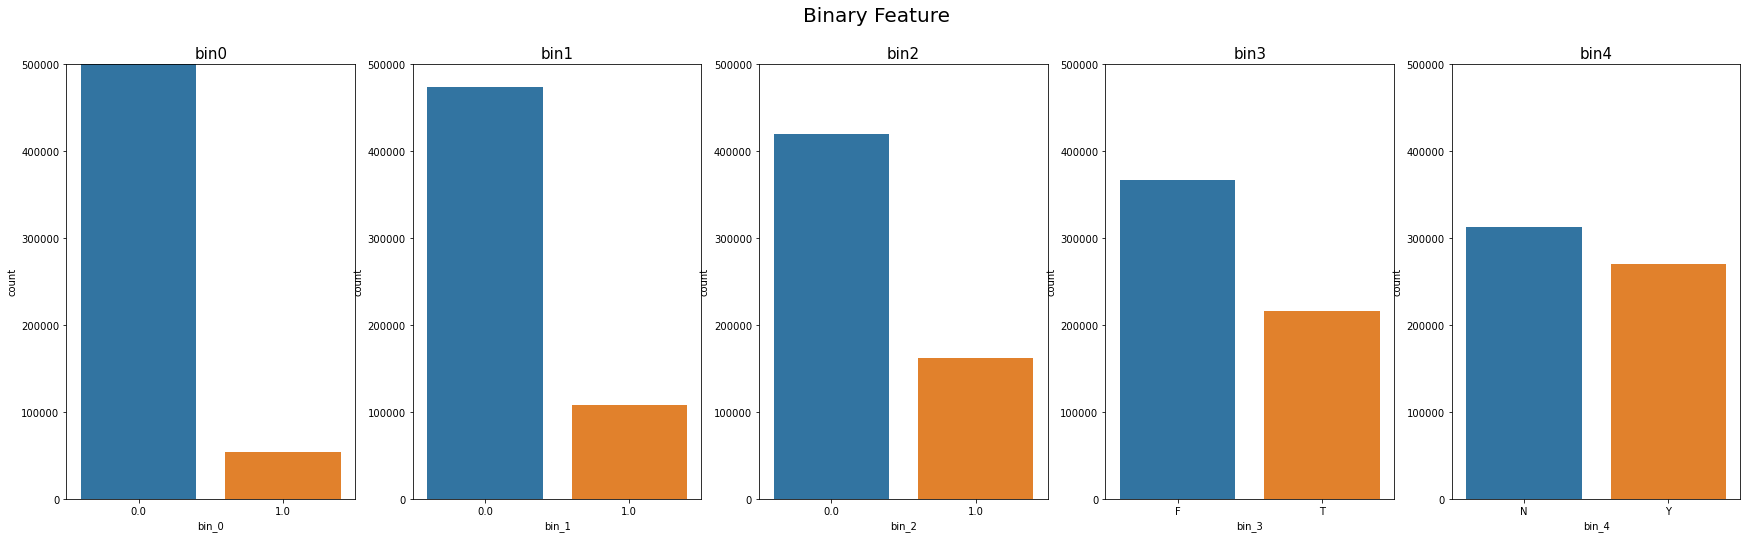

In [4]:
fig, axes = plt.subplots(1,5,figsize = (30,8))

for i in range(5):
    sns.countplot(f'bin_{i}', data = train_df, ax = axes[i])
    axes[i].set_ylim([0, 500000])
    axes[i].set_title(f'bin{i}', fontsize = 15)

fig.suptitle("Binary Feature", fontsize = 20)
plt.show()

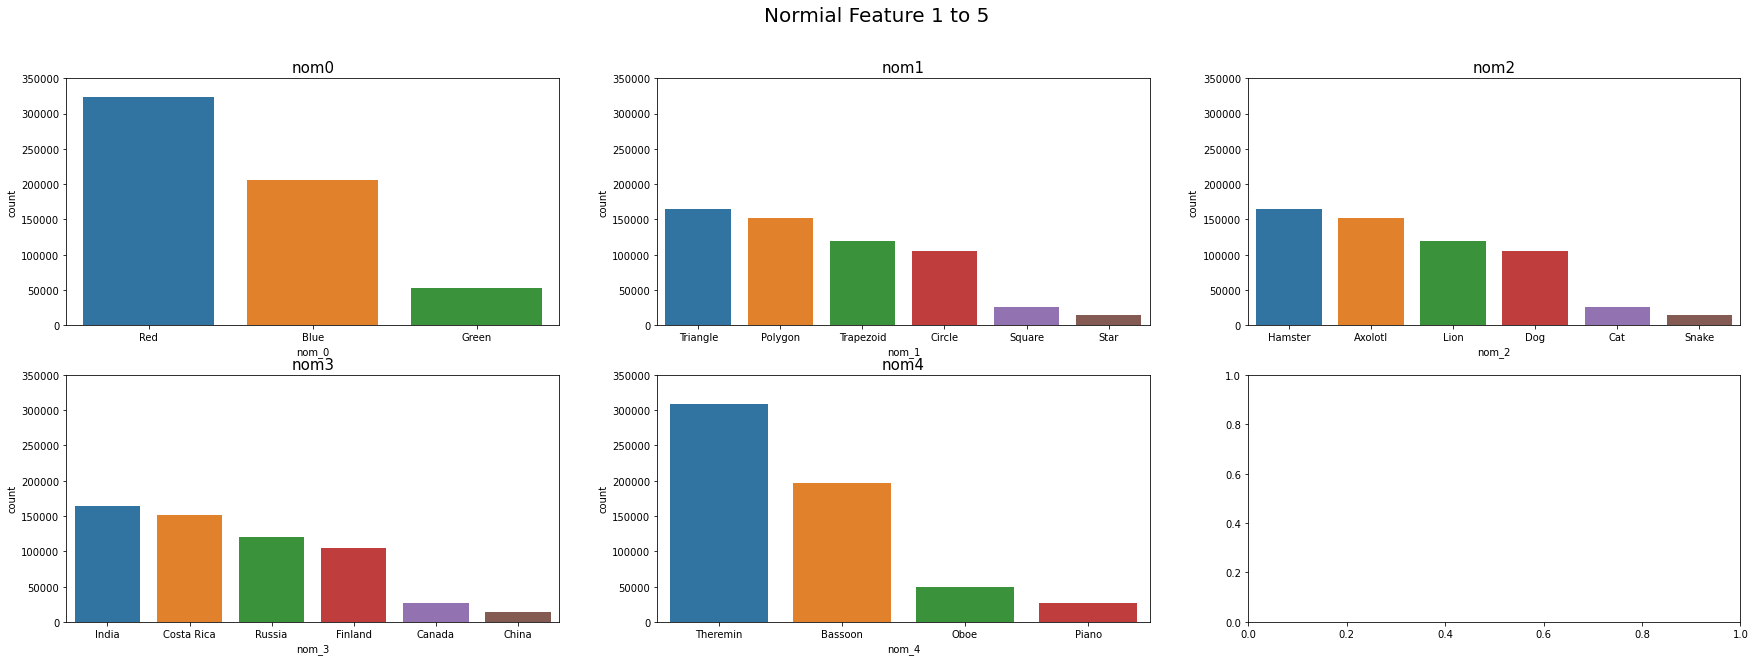

In [5]:
fig, axes = plt.subplots(2, 3, figsize = (30, 10))

for i in range(5):
    sns.countplot(f'nom_{i}', data = train_df, ax = axes[i // 3][i%3],
                 order = train_df[f'nom_{i}'].value_counts().index)
    axes[i//3][i%3].set_ylim([0, 350000])
    axes[i//3][i%3].set_title(f'nom{i}', fontsize = 15)

fig.suptitle("Normial Feature 1 to 5", fontsize = 20)
plt.show()

In [6]:
train_df['nom_6'].value_counts()

ea8c5e181    805
9fa481341    798
2b94ada45    792
32e9bd1ff    788
b88220966    781
            ... 
f0732a795      4
322548bed      3
d6ea07c05      2
b4b8de4b9      2
3a121fefb      1
Name: nom_6, Length: 1519, dtype: int64

In [7]:
train_df[[f'nom_{i}' for i in range(5, 10)]].describe()

,nom_5,nom_6,nom_7,nom_8,nom_9
count,582222,581869,581997,582245,581927
unique,1220,1519,222,222,2218
top,fc8fc7e56,ea8c5e181,4ae48e857,7d7c02c57,8f3276a6e
freq,977,805,5035,5052,565


nom_5 ~ nom_9는 unique value가 상당히 많다는 것을 알 수 있다.

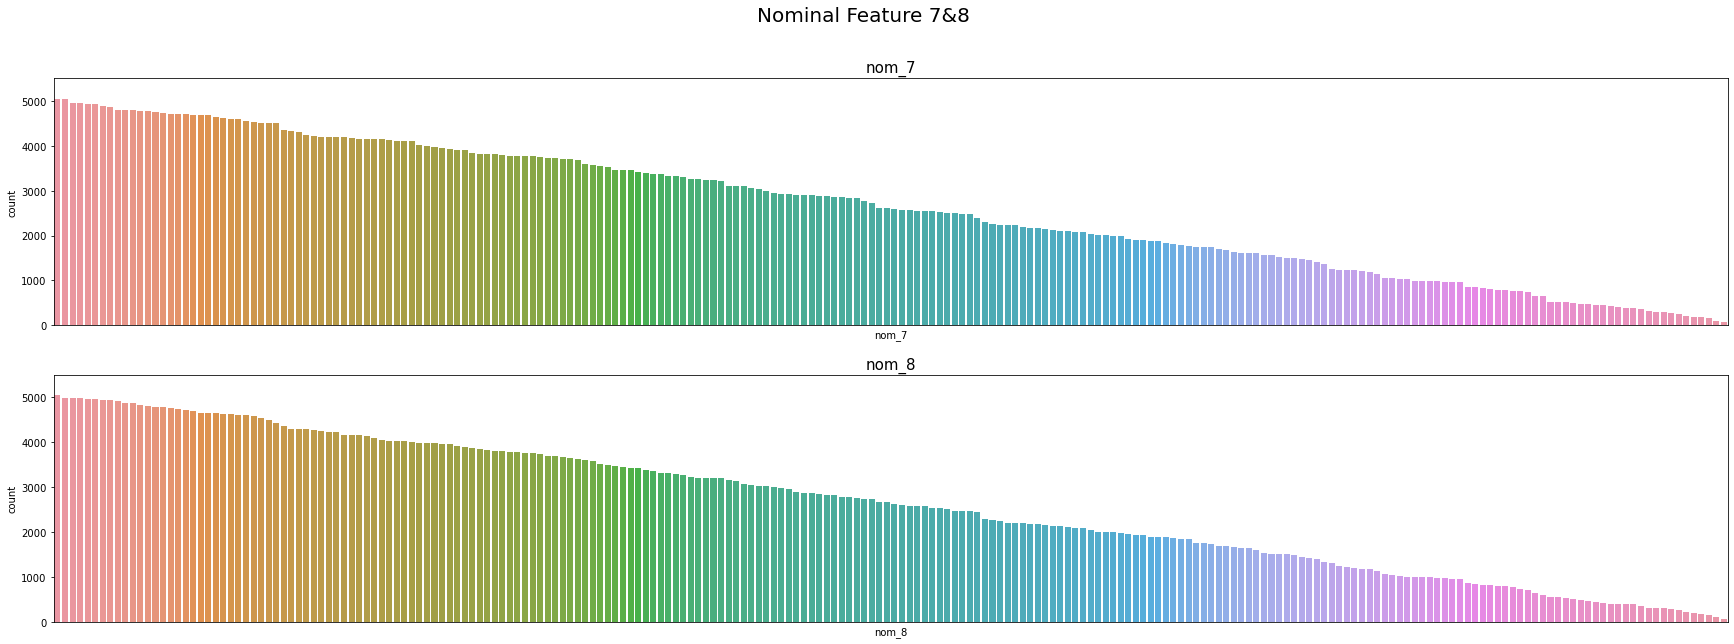

In [8]:
fig, ax = plt.subplots(2,1, figsize=(30, 10))
for i in range(7,9): 
    sns.countplot(f'nom_{i}', data= train_df, ax=ax[i-7],
                  order = train_df[f'nom_{i}'].dropna().value_counts().index)
    ax[i-7].set_ylim([0, 5500])
    ax[i-7].set_title(f'nom_{i}', fontsize=15)
    ax[i-7].set_xticks([])
fig.suptitle("Nominal Feature 7&8", fontsize=20)
plt.show()

In [9]:
train_df[[f'ord_{i}' for i in range(6)]].describe(include = 'all')

,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5
count,581712.000000,581959,581925,582084,582070,582287
unique,NaN,5,6,15,26,190
top,NaN,Novice,Freezing,n,N,Fl
freq,NaN,160597,142726,70982,39978,10562
mean,1.948224,NaN,NaN,NaN,NaN,NaN
std,0.853904,NaN,NaN,NaN,NaN,NaN
min,1.000000,NaN,NaN,NaN,NaN,NaN
25%,1.000000,NaN,NaN,NaN,NaN,NaN
50%,2.000000,NaN,NaN,NaN,NaN,NaN
75%,3.000000,NaN,NaN,NaN,NaN,NaN


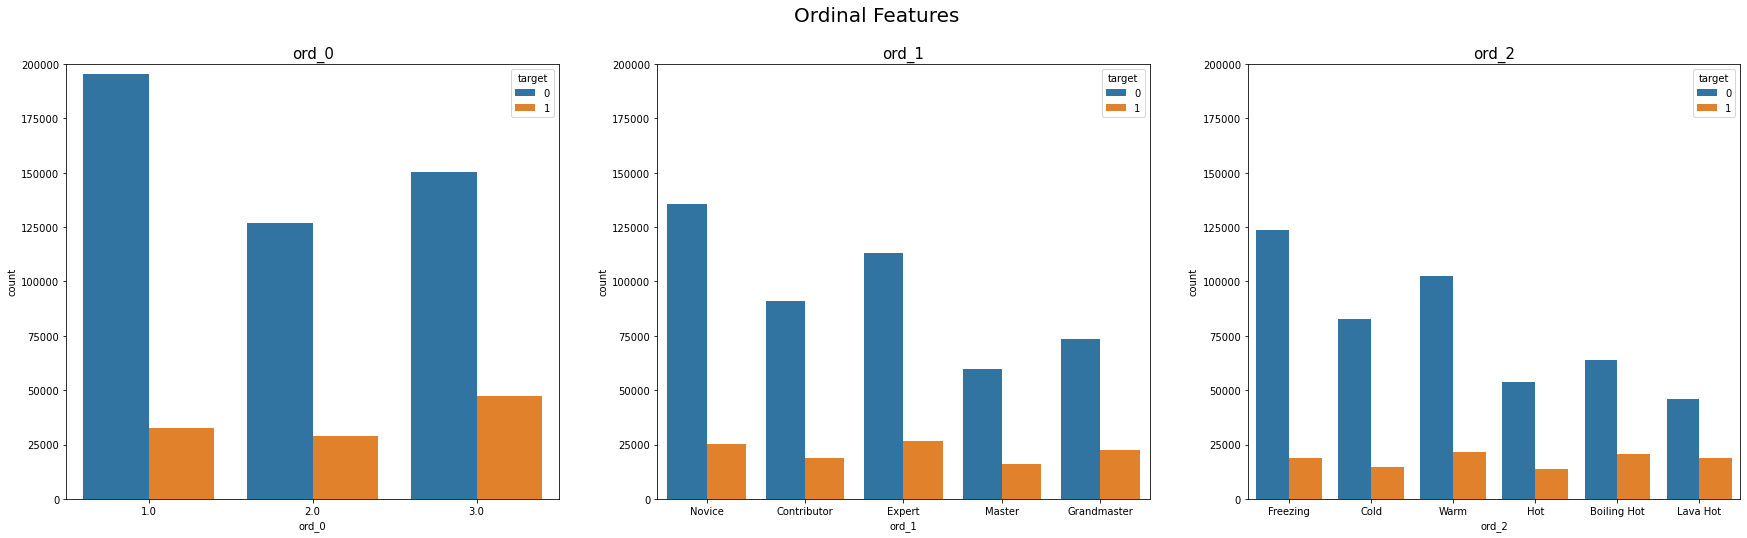

In [10]:
fig, ax = plt.subplots(1,3, figsize=(30, 8))

ord_order = [
    [1.0, 2.0, 3.0],
    ['Novice', 'Contributor', 'Expert', 'Master', 'Grandmaster'],
    ['Freezing', 'Cold', 'Warm', 'Hot', 'Boiling Hot', 'Lava Hot']
]

for i in range(3): 
    sns.countplot(f'ord_{i}', hue='target', data= train_df, ax=ax[i],
                  order = ord_order[i])
                 
    ax[i].set_ylim([0, 200000])
    ax[i].set_title(f'ord_{i}', fontsize=15)
fig.suptitle("Ordinal Features", fontsize=20)
plt.show()

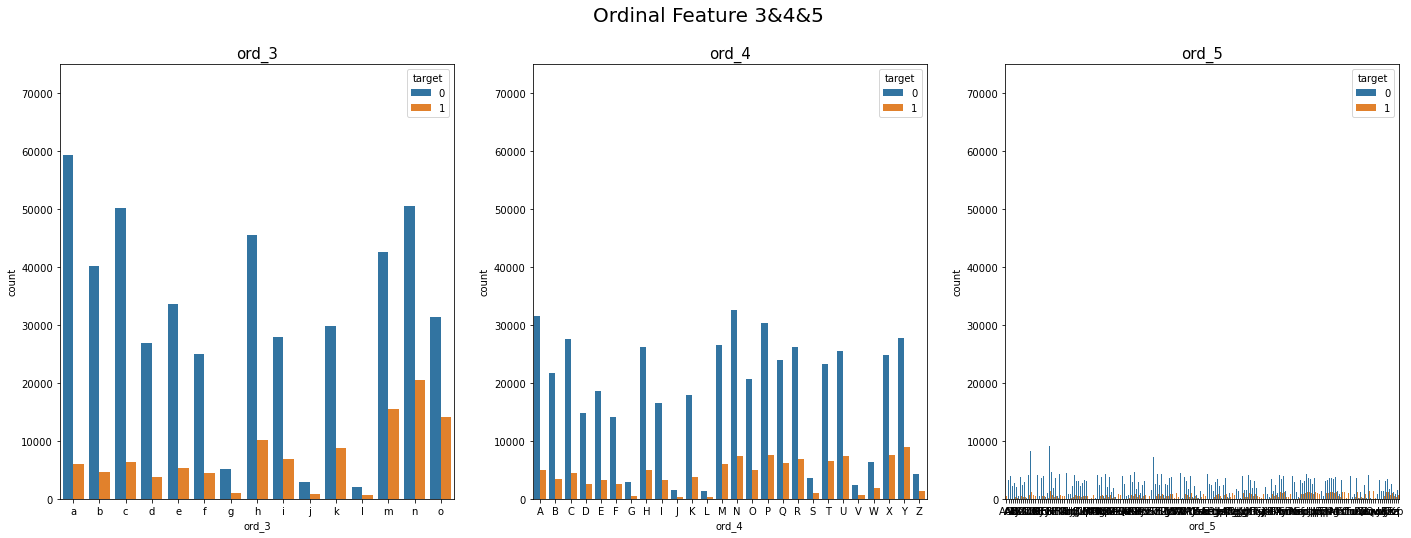

In [11]:
fig, ax = plt.subplots(1,3, figsize=(24, 8))

for i in range(3, 6): 
    sns.countplot(f'ord_{i}', hue='target', data= train_df, ax=ax[i-3],
                  order = sorted(train_df[f'ord_{i}'].dropna().unique())
                 )
    ax[i-3].set_ylim([0, 75000])
    ax[i-3].set_title(f'ord_{i}', fontsize=15)
fig.suptitle("Ordinal Feature 3&4&5", fontsize=20)
plt.show()

In [12]:
train_df['day'].value_counts()

3.0    113835
5.0    110464
6.0     97432
7.0     86435
1.0     84724
2.0     65495
4.0     23663
Name: day, dtype: int64

## Missing Data Handling

In [13]:
X_train = train_df.iloc[:, :-1]
y_train = train_df[['target']]
X_test = test_df

In [14]:
X_train = X_train.sample(frac=0.2, random_state=42)
y_train = y_train.sample(frac=0.2, random_state=42)

In [15]:
X_train_imp, X_test_imp = X_train.copy(), X_test.copy()

In [16]:
X_train_imp = X_train_imp.drop(['id'],axis=1)
X_test_imp = X_test_imp.drop(['id'],axis=1)

In [17]:
col = X_train_imp.columns.to_list()

In [18]:
print(X_train_imp.isnull().sum(), '\n')
print(X_test_imp.isnull().sum())

bin_0    3615
bin_1    3672
bin_2    3560
bin_3    3694
bin_4    3622
nom_0    3569
nom_1    3662
nom_2    3593
nom_3    3676
nom_4    3694
nom_5    3553
nom_6    3694
nom_7    3576
nom_8    3635
nom_9    3554
ord_0    3608
ord_1    3606
ord_2    3565
ord_3    3604
ord_4    3536
ord_5    3555
day      3526
month    3651
dtype: int64 

bin_0    11901
bin_1    12038
bin_2    11972
bin_3    11951
bin_4    11951
nom_0    12062
nom_1    11947
nom_2    12179
nom_3    12176
nom_4    11993
nom_5    11912
nom_6    12012
nom_7    12003
nom_8    11956
nom_9    12060
ord_0    11893
ord_1    12167
ord_2    12105
ord_3    12053
ord_4    11933
ord_5    12047
day      12025
month    11984
dtype: int64


In [19]:
from sklearn.impute import SimpleImputer 
imp = SimpleImputer(strategy="most_frequent")
X_train_imp[col] = imp.fit_transform(X_train_imp[col])
X_test_imp[col] = imp.transform(X_test_imp[col])

In [20]:
print(X_train_imp.isnull().sum(), '\n')
print(X_test_imp.isnull().sum())

bin_0    0
bin_1    0
bin_2    0
bin_3    0
bin_4    0
nom_0    0
nom_1    0
nom_2    0
nom_3    0
nom_4    0
nom_5    0
nom_6    0
nom_7    0
nom_8    0
nom_9    0
ord_0    0
ord_1    0
ord_2    0
ord_3    0
ord_4    0
ord_5    0
day      0
month    0
dtype: int64 

bin_0    0
bin_1    0
bin_2    0
bin_3    0
bin_4    0
nom_0    0
nom_1    0
nom_2    0
nom_3    0
nom_4    0
nom_5    0
nom_6    0
nom_7    0
nom_8    0
nom_9    0
ord_0    0
ord_1    0
ord_2    0
ord_3    0
ord_4    0
ord_5    0
day      0
month    0
dtype: int64


In [21]:
lst = ['bin_0','bin_1','bin_2','ord_0','day','month']
X_train_imp[lst] = X_train_imp[lst].astype(int)
X_test_imp[lst] = X_test_imp[lst].astype(int)

In [22]:
X_train_imp.dtypes

bin_0     int64
bin_1     int64
bin_2     int64
bin_3    object
bin_4    object
nom_0    object
nom_1    object
nom_2    object
nom_3    object
nom_4    object
nom_5    object
nom_6    object
nom_7    object
nom_8    object
nom_9    object
ord_0     int64
ord_1    object
ord_2    object
ord_3    object
ord_4    object
ord_5    object
day       int64
month     int64
dtype: object

In [23]:
X_test_imp.dtypes

bin_0     int64
bin_1     int64
bin_2     int64
bin_3    object
bin_4    object
nom_0    object
nom_1    object
nom_2    object
nom_3    object
nom_4    object
nom_5    object
nom_6    object
nom_7    object
nom_8    object
nom_9    object
ord_0     int64
ord_1    object
ord_2    object
ord_3    object
ord_4    object
ord_5    object
day       int64
month     int64
dtype: object

## 전체 피처 고유값 나타내기

In [24]:
df = pd.DataFrame(X_train_imp.dtypes, columns=['data_type']).reset_index()

In [25]:
df = df.rename(columns={'index': 'Feature'})

In [26]:
df['고유값 개수'] = X_train_imp.nunique().values

In [27]:
df

,Feature,data_type,고유값 개수
0,bin_0,int64,2
1,bin_1,int64,2
2,bin_2,int64,2
3,bin_3,object,2
4,bin_4,object,2
5,nom_0,object,3
6,nom_1,object,6
7,nom_2,object,6
8,nom_3,object,6
9,nom_4,object,4


In [28]:
features = X_train_imp.columns.to_list()

for feature in features:
    print(feature,':', X_train_imp[feature].unique())

bin_0 : [0 1]
bin_1 : [1 0]
bin_2 : [1 0]
bin_3 : ['T' 'F']
bin_4 : ['N' 'Y']
nom_0 : ['Red' 'Blue' 'Green']
nom_1 : ['Trapezoid' 'Polygon' 'Circle' 'Triangle' 'Square' 'Star']
nom_2 : ['Hamster' 'Lion' 'Axolotl' 'Dog' 'Cat' 'Snake']
nom_3 : ['India' 'Russia' 'Finland' 'Costa Rica' 'China' 'Canada']
nom_4 : ['Theremin' 'Bassoon' 'Oboe' 'Piano']
nom_5 : ['660786af9' 'be1386f10' '07134e36b' ... '30019ce8a' '8116aba72'
 '89f532300']
nom_6 : ['1d0b86c1a' '7f2775330' '017d385e1' ... '27fadf6ea' 'b61f2c984'
 '99f4e90fe']
nom_7 : ['1dddb8473' 'c5f7d2efd' 'ba16219f4' 'a7059911d' '22a1b223f' '31a3c86df'
 '5d5b262b1' '99cb99a50' '114b1dbf3' 'e5b00a0e0' '1c756c04a' '934155e05'
 '0eb5e9781' '6e29d3f38' '3d9d8f526' 'd2ecbd100' '67a8d4ebb' '3f2e87b23'
 '7b4b2eabf' '2c4f9614e' '4f0a50007' '5627228e9' 'ece4087ec' '230229e51'
 '7ab87e58e' '303f4e39a' '4ae48e857' '8402256f6' '1bf2f7824' '8da514edb'
 '58a27d7e7' '3d449d3e8' 'f12d5e8c0' '3f63ecb96' '018382adf' '580231f65'
 'e60e65034' '088aace2d' '5ddc9a7

- 전체 피처의 고윳값은 위와 같다.

## 1. 이진(Binary) 피처 : bin_0 ~ bin_4

- bin_0, bin_1, bin_2는 float64 데이터타입이고, 0 또는 1로 구성되어 있음

- bin_3, bin_4는 object 데이터타입이고, T or F / Y or N 으로 구성되어 있음

- T, Y는 1로, F, N은 0으로 인코딩


In [29]:
for i in range(5):
    feature = 'bin_' + str(i)
    print(f'{feature} 고유값: {X_train_imp[feature].unique()}')

bin_0 고유값: [0 1]
bin_1 고유값: [1 0]
bin_2 고유값: [1 0]
bin_3 고유값: ['T' 'F']
bin_4 고유값: ['N' 'Y']


- 0, 1로 바꾸기

In [30]:
X_train_imp['bin_3'] = X_train_imp['bin_3'].map({'F':0, 'T':1})
X_train_imp['bin_4'] = X_train_imp['bin_4'].map({'N':0, 'Y':1})

In [31]:
X_test_imp['bin_3'] = X_test_imp['bin_3'].map({'F':0, 'T':1})
X_test_imp['bin_4'] = X_test_imp['bin_4'].map({'N':0, 'Y':1})

In [32]:
display(X_train_imp, X_test_imp)

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
4242,0,1,1,1,0,Red,Trapezoid,Hamster,India,Theremin,...,da7e5f6fa,e4dca5162,1,Contributor,Cold,b,X,XR,7,12
60608,0,0,1,0,1,Blue,Polygon,Lion,India,Bassoon,...,bd9643a20,a3841a77d,2,Master,Warm,n,K,hG,1,8
392832,1,0,1,0,1,Blue,Circle,Axolotl,Russia,Theremin,...,7e3a861d6,a14975181,1,Novice,Freezing,f,X,aE,7,12
41643,0,0,1,0,1,Blue,Triangle,Lion,Finland,Theremin,...,46a005ddf,685879709,2,Novice,Freezing,f,Y,kT,3,12
464234,0,1,0,0,0,Red,Trapezoid,Axolotl,India,Theremin,...,862d2fbff,2fb5641aa,1,Master,Hot,o,A,Hk,5,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209840,0,1,0,1,1,Red,Triangle,Lion,India,Theremin,...,d9148f8e7,8728df384,1,Contributor,Freezing,n,A,Nh,3,5
241247,0,0,0,0,1,Blue,Polygon,Axolotl,Costa Rica,Bassoon,...,b4815ac52,81a0d0a92,1,Grandmaster,Hot,n,F,iS,4,8
583530,0,0,0,1,0,Green,Polygon,Hamster,India,Oboe,...,bccfd92a2,7afa2935e,2,Master,Warm,m,E,dh,6,5
285430,0,0,1,0,0,Red,Triangle,Axolotl,Costa Rica,Bassoon,...,e40c451d4,602d7a9af,2,Contributor,Freezing,o,N,Ib,5,5


,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0,0,0,0,1,Blue,Polygon,Axolotl,Finland,Piano,...,ca9ad1d4b,fced9e114,3,Novice,Boiling Hot,f,U,oU,3,9
1,0,0,0,0,1,Red,Circle,Lion,Russia,Bassoon,...,060a21580,7ca8775da,1,Novice,Cold,n,N,Fl,2,8
2,0,0,0,0,1,Blue,Circle,Axolotl,Russia,Theremin,...,165e81a00,5940334c9,1,Expert,Warm,i,N,DN,2,6
3,1,0,0,0,0,Red,Polygon,Axolotl,Costa Rica,Bassoon,...,77d41330d,6fbdeefc8,1,Expert,Hot,m,B,AG,1,6
4,0,0,1,0,1,Red,Circle,Hamster,Finland,Theremin,...,2218d9dfe,2a27c8fde,1,Contributor,Lava Hot,o,J,DT,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,0,0,1,1,0,Red,Trapezoid,Axolotl,Costa Rica,Theremin,...,c1a4acfaf,45a68dd2e,2,Expert,Warm,n,R,dp,2,12
399996,0,0,0,0,0,Red,Polygon,Dog,Russia,Theremin,...,220190c9e,e48348d66,1,Contributor,Freezing,n,X,US,1,5
399997,0,0,1,1,0,Red,Triangle,Hamster,India,Theremin,...,cc5495ab3,47021df0d,1,Grandmaster,Boiling Hot,m,P,TL,1,6
399998,0,0,0,0,1,Red,Circle,Dog,Costa Rica,Theremin,...,32b33a4b4,e4bf32721,3,Novice,Lava Hot,h,L,DI,2,11


## 2. 명목형(Nominal) 피처: nom_0 ~ nom_9

- nom_0 ~ nom_9의 데이터타입은 object임

- nom_0부터 nom_4는 고유값이 6개 이하임.

- nom_5부터 nom_9의 고유값이 많음.

In [33]:
for i in range(10):
    feature = 'nom_' + str(i)
    print(f'{feature} 고유값: {X_train_imp[feature].unique()}')

nom_0 고유값: ['Red' 'Blue' 'Green']
nom_1 고유값: ['Trapezoid' 'Polygon' 'Circle' 'Triangle' 'Square' 'Star']
nom_2 고유값: ['Hamster' 'Lion' 'Axolotl' 'Dog' 'Cat' 'Snake']
nom_3 고유값: ['India' 'Russia' 'Finland' 'Costa Rica' 'China' 'Canada']
nom_4 고유값: ['Theremin' 'Bassoon' 'Oboe' 'Piano']
nom_5 고유값: ['660786af9' 'be1386f10' '07134e36b' ... '30019ce8a' '8116aba72'
 '89f532300']
nom_6 고유값: ['1d0b86c1a' '7f2775330' '017d385e1' ... '27fadf6ea' 'b61f2c984'
 '99f4e90fe']
nom_7 고유값: ['1dddb8473' 'c5f7d2efd' 'ba16219f4' 'a7059911d' '22a1b223f' '31a3c86df'
 '5d5b262b1' '99cb99a50' '114b1dbf3' 'e5b00a0e0' '1c756c04a' '934155e05'
 '0eb5e9781' '6e29d3f38' '3d9d8f526' 'd2ecbd100' '67a8d4ebb' '3f2e87b23'
 '7b4b2eabf' '2c4f9614e' '4f0a50007' '5627228e9' 'ece4087ec' '230229e51'
 '7ab87e58e' '303f4e39a' '4ae48e857' '8402256f6' '1bf2f7824' '8da514edb'
 '58a27d7e7' '3d449d3e8' 'f12d5e8c0' '3f63ecb96' '018382adf' '580231f65'
 'e60e65034' '088aace2d' '5ddc9a726' '8a382f14d' '623908296' '20b56638c'
 '8a528cb08' '

- nom_0 ~ nom_4 : One-Hot-Encoding으로 

In [34]:
nom01234 = ['nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4']

X_all_imp = pd.concat([X_train_imp, X_test_imp])
X_all_imp = pd.get_dummies(X_all_imp, columns=nom01234)

In [35]:
X_train_imp = X_all_imp.iloc[:X_train_imp.shape[0],:].reset_index(drop=True)
X_test_imp = X_all_imp.iloc[X_train_imp.shape[0]:,:].reset_index(drop=True)

## 3. 순서형(Ordinal) 피처: ord_0 ~ ord_5

- ord_0 피처의 데이터타입은 int이고, 나머지는 object타입임.

- 순서에 유의하며 인코딩

In [36]:
for i in range(3):
    feature = 'ord_' + str(i)
    print(f'{feature} 고유값: {X_train_imp[feature].unique()}')

ord_0 고유값: [1 2 3]
ord_1 고유값: ['Contributor' 'Master' 'Novice' 'Expert' 'Grandmaster']
ord_2 고유값: ['Cold' 'Warm' 'Freezing' 'Hot' 'Lava Hot' 'Boiling Hot']


- ord_0 피처는 이미 숫자로 구성되어 있음

- ord_1과 ord_2 피처는 숫자를 지정해서 인코딩 진행

In [37]:
ord1 = {'Novice':0, 'Contributor':1, 'Expert':2, 'Master':3, 'Grandmaster':4}
ord2 = {'Freezing':0, 'Cold':1, 'Warm':2, 'Hot':3, 'Boiling Hot':4, 'Lava Hot':5}

In [38]:
X_train_imp['ord_1'] = X_train_imp['ord_1'].map(ord1)
X_train_imp['ord_2'] = X_train_imp['ord_2'].map(ord2)

In [39]:
X_test_imp['ord_1'] = X_test_imp['ord_1'].map(ord1)
X_test_imp['ord_2'] = X_test_imp['ord_2'].map(ord2)

In [40]:
for i in range(3, 6):
    feature = 'ord_' + str(i)
    print(f'{feature} 고유값: {X_train_imp[feature].unique()}')


ord_3 고유값: ['b' 'n' 'f' 'o' 'm' 'h' 'd' 'c' 'i' 'k' 'a' 'e' 'g' 'j' 'l']
ord_4 고유값: ['X' 'K' 'Y' 'A' 'P' 'B' 'Q' 'R' 'N' 'M' 'S' 'T' 'I' 'E' 'F' 'Z' 'C' 'W'
 'H' 'U' 'O' 'J' 'D' 'G' 'V' 'L']
ord_5 고유값: ['XR' 'hG' 'aE' 'kT' 'Hk' 'AG' 'Mg' 'zc' 'zf' 'tn' 'rM' 'xF' 'OM' 'JQ'
 'Ib' 'gt' 'TZ' 'th' 'DR' 'GZ' 'sc' 'be' 'ly' 'ep' 'al' 'DI' 'AW' 'ok'
 'Ji' 'RT' 'mD' 'Ey' 'Nh' 'lR' 'rg' 'dh' 'cg' 'fV' 'UV' 'Bx' 'hT' 'BL'
 'Ro' 'Fl' 'uZ' 'fO' 'TL' 'sf' 'Iq' 'ne' 'pE' 'nS' 'PS' 'rl' 'Dj' 'hx'
 'AU' 'LY' 'Re' 'RB' 'dp' 'Yi' 'jf' 'cy' 'DN' 'mX' 'eN' 'qN' 'HO' 'NT'
 'Kq' 'sY' 'rA' 'JT' 'pT' 'NS' 'Sz' 'US' 'BX' 'IS' 'MU' 'xG' 'EC' 'RD'
 'mo' 'oI' 'Rv' 'AI' 'TH' 'XC' 'wa' 'Ox' 'Mq' 'Wr' 'us' 'WW' 'oJ' 'In'
 'XM' 'uQ' 'kv' 'pZ' 'yE' 'CU' 'LS' 'vx' 'OZ' 'TP' 'Rj' 'nj' 'DT' 'Pk'
 'Lo' 'vq' 'Ty' 'oh' 'pB' 'SS' 'HF' 'lA' 'Io' 'gc' 'FH' 'cY' 'Pw' 'iv'
 'YJ' 'RV' 'nn' 'mi' 'oU' 'MV' 'ht' 'gK' 'CN' 'zp' 'pl' 'qP' 'uP' 'lS'
 'jp' 'Sk' 'Rz' 'Tz' 'ur' 'fe' 'HK' 'gj' 'QV' 'ze' 'XU' 'IA' 'Oe' 'iS'
 'sF' 'fF' 'xB' '

- ord_3 ~ ord_5피처는 알파벳이므로 Oridinal Encoding으로

### - ord_3, ord_4, ord_5 피처는 알파벳순으로 정렬되어 있으므로 추후 알파벳순으로 인코딩

In [41]:
from sklearn.preprocessing import OrdinalEncoder

ord_345 = ['ord_3', 'ord_4', 'ord_5']

ord_encoder = OrdinalEncoder()  

X_train_imp[ord_345] = ord_encoder.fit_transform(X_train_imp[ord_345])
X_test_imp[ord_345] = ord_encoder.transform(X_test_imp[ord_345])
 
for feature, categories in zip(ord_345, ord_encoder.categories_):
    print(feature)
    print(categories)

ord_3
['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o']
ord_4
['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']
ord_5
['AG' 'AI' 'AU' 'AW' 'Ay' 'BL' 'BX' 'Bx' 'CN' 'CU' 'Cn' 'DI' 'DN' 'DR'
 'DT' 'Dj' 'Dn' 'EC' 'Ey' 'FB' 'FH' 'Fl' 'GZ' 'HF' 'HK' 'HO' 'Hk' 'IA'
 'IS' 'Ib' 'In' 'Io' 'Iq' 'JQ' 'JT' 'Ji' 'Kq' 'LS' 'LY' 'Lo' 'MF' 'MU'
 'MV' 'MX' 'Mg' 'Mq' 'NS' 'NT' 'Nh' 'OM' 'OZ' 'Oe' 'Ox' 'PG' 'PS' 'Pk'
 'Pw' 'QV' 'Qm' 'RB' 'RD' 'RT' 'RV' 'Re' 'Rj' 'Ro' 'Rv' 'Rz' 'SL' 'SS'
 'Sk' 'Sz' 'TH' 'TL' 'TP' 'TZ' 'Tg' 'Ty' 'Tz' 'US' 'UV' 'WC' 'WW' 'Wr'
 'XC' 'XI' 'XM' 'XR' 'XU' 'YJ' 'Yb' 'Yi' 'Yr' 'Zv' 'aA' 'aE' 'al' 'be'
 'cR' 'cY' 'cg' 'cy' 'dh' 'dp' 'eA' 'eN' 'ep' 'fF' 'fO' 'fV' 'fe' 'gK'
 'gL' 'gV' 'gc' 'gj' 'gt' 'hG' 'hT' 'ht' 'hx' 'iS' 'iv' 'ja' 'jf' 'jp'
 'kB' 'kP' 'kT' 'kv' 'lA' 'lR' 'lS' 'ly' 'mD' 'mP' 'mX' 'mi' 'mo' 'nS'
 'ne' 'nf' 'nj' 'nn' 'oI' 'oJ' 'oU' 'oh' 'ok' 'pB' 'pE' 'pT' 'pZ' 'pl'
 'qN' 'qP' 'rA' 'rM' 'rg' 'rl' '

In [42]:
X_train_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 43 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   bin_0             120000 non-null  int64  
 1   bin_1             120000 non-null  int64  
 2   bin_2             120000 non-null  int64  
 3   bin_3             120000 non-null  int64  
 4   bin_4             120000 non-null  int64  
 5   nom_5             120000 non-null  object 
 6   nom_6             120000 non-null  object 
 7   nom_7             120000 non-null  object 
 8   nom_8             120000 non-null  object 
 9   nom_9             120000 non-null  object 
 10  ord_0             120000 non-null  int64  
 11  ord_1             120000 non-null  int64  
 12  ord_2             120000 non-null  int64  
 13  ord_3             120000 non-null  float64
 14  ord_4             120000 non-null  float64
 15  ord_5             120000 non-null  float64
 16  day               12

## 4. Cylical 피처: day, month

In [43]:
print('day 고유값', X_train_imp['day'].unique())
print('month 고유값', X_train_imp['month'].unique())
# print('target 고윳값', X_train_imp_target.unique())

day 고유값 [7 1 3 5 6 2 4]
month 고유값 [12  8  3  6 11  5  7  2  1 10  9  4]


In [44]:
feature_4 = col[-2::]

In [45]:
X_train_imp[feature_4]

,day,month
0,7,12
1,1,8
2,7,12
3,3,12
4,5,12
...,...,...
119995,3,5
119996,4,8
119997,6,5
119998,5,5


In [46]:
X_all_imp = pd.concat([X_train_imp, X_test_imp])
X_all_imp = pd.get_dummies(X_all_imp, columns=feature_4, sparse=True)

X_train_imp = X_all_imp.iloc[:X_train_imp.shape[0], :].reset_index(drop=True)
X_test_imp = X_all_imp.iloc[X_train_imp.shape[0]:, :].reset_index(drop=True)

X_train_imp

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,1,1,1,0,660786af9,1d0b86c1a,1dddb8473,da7e5f6fa,e4dca5162,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,1,be1386f10,7f2775330,c5f7d2efd,bd9643a20,a3841a77d,...,0,0,0,0,0,1,0,0,0,0
2,1,0,1,0,1,07134e36b,017d385e1,ba16219f4,7e3a861d6,a14975181,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,1,6f6006d40,5a7f10cb2,a7059911d,46a005ddf,685879709,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,36f0df6bb,76123dffc,22a1b223f,862d2fbff,2fb5641aa,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0,1,0,1,1,87a5be0d7,68e30f8b6,e06abf51f,d9148f8e7,8728df384,...,0,0,1,0,0,0,0,0,0,0
119996,0,0,0,0,1,88eb42f47,8931fec8c,934155e05,b4815ac52,81a0d0a92,...,0,0,0,0,0,1,0,0,0,0
119997,0,0,0,1,0,2bdcb23cc,e5c1e6807,afac5238e,bccfd92a2,7afa2935e,...,0,0,1,0,0,0,0,0,0,0
119998,0,0,1,0,0,65a2ffcd1,ed3b61c13,3d9d8f526,e40c451d4,602d7a9af,...,0,0,1,0,0,0,0,0,0,0


- nom_5 ~ nom_9(카디널리티가 높은거): Target, James-Stein, Weight of Evidence, LeaveOneOut Encoding, M-Estimate Encoder, CatBoost Encoding 6개로 조합하기


In [47]:
nom56789 = ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9']

In [48]:
y_train = y_train.reset_index(drop=True)

### _Target Encoding_

In [49]:
te = ce.TargetEncoder(cols=nom56789, min_samples_leaf=5 , smoothing=50)

X_train_imp_te, X_test_imp_te, = X_train_imp.copy(), X_test_imp.copy()

X_train_imp_te[nom56789] = te.fit_transform(X_train_imp[nom56789], y_train)
X_test_imp_te[nom56789] = te.transform(X_test_imp[nom56789])

X_train_imp_te

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,1,1,1,0,0.262328,0.128631,0.131027,0.145917,0.204208,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,1,0.129535,0.198863,0.230681,0.174864,0.188494,...,0,0,0,0,0,1,0,0,0,0
2,1,0,1,0,1,0.200662,0.211343,0.188437,0.126761,0.099698,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,1,0.192088,0.196837,0.191053,0.231750,0.153393,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0.175074,0.159435,0.189487,0.256219,0.208952,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0,1,0,1,1,0.171334,0.241616,0.221198,0.144196,0.252825,...,0,0,1,0,0,0,0,0,0,0
119996,0,0,0,0,1,0.178257,0.223194,0.190068,0.165182,0.238707,...,0,0,0,0,0,1,0,0,0,0
119997,0,0,0,1,0,0.154856,0.206465,0.217050,0.186176,0.166236,...,0,0,1,0,0,0,0,0,0,0
119998,0,0,1,0,0,0.176253,0.285800,0.195450,0.219400,0.153895,...,0,0,1,0,0,0,0,0,0,0


In [50]:
lr_te = LogisticRegression(random_state=42)
lr_te.fit(X_train_imp_te, y_train)

pd.DataFrame({'id': X_test['id'], 'target': lr_te.predict_proba(X_test_imp_te)[:,1]}).to_csv('submission_lr_te.csv', index=False)

In [51]:
dt_te = DecisionTreeClassifier(max_depth= 3, random_state=42)
dt_te.fit(X_train_imp_te, y_train)

pd.DataFrame({'id': X_test['id'], 'target': dt_te.predict_proba(X_test_imp_te)[:,1]}).to_csv('submission_dt_te.csv', index=False)

In [52]:
mlp_te = MLPClassifier(random_state=42)
mlp_te.fit(X_train_imp_te, y_train)

pd.DataFrame({'id' : X_test['id'], 'target' : mlp_te.predict_proba(X_test_imp_te)[:,1]}).to_csv('submission_mlp_te.csv',index=False)

### _James-Stein Encoding_

In [53]:
js_encoder = ce.JamesSteinEncoder(cols=nom56789)

X_train_imp_js, X_test_imp_js, = X_train_imp.copy(), X_test_imp.copy()

X_train_imp_js[nom56789] = js_encoder.fit_transform(X_train_imp[nom56789], y_train)
X_test_imp_js[nom56789] = js_encoder.transform(X_test_imp[nom56789])

X_train_imp_js

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,1,1,1,0,0.229273,0.147358,0.154547,0.163999,0.197779,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,1,0.147058,0.192965,0.206969,0.180411,0.187598,...,0,0,0,0,0,1,0,0,0,0
2,1,0,1,0,1,0.193517,0.199535,0.187389,0.151691,0.109915,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,1,0.189696,0.192939,0.188692,0.207430,0.160721,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0.178061,0.164628,0.187913,0.217629,0.198834,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0,1,0,1,1,0.178408,0.213162,0.202809,0.162951,0.224629,...,0,0,1,0,0,0,0,0,0,0
119996,0,0,0,0,1,0.182054,0.206036,0.188202,0.175175,0.218471,...,0,0,0,0,0,1,0,0,0,0
119997,0,0,0,1,0,0.167819,0.197004,0.201084,0.186254,0.174353,...,0,0,1,0,0,0,0,0,0,0
119998,0,0,1,0,0,0.180892,0.235887,0.190848,0.202010,0.165335,...,0,0,1,0,0,0,0,0,0,0


In [54]:
lr_js = LogisticRegression(random_state=42)
lr_js.fit(X_train_imp_js, y_train)

pd.DataFrame({'id': X_test['id'], 'target': lr_js.predict_proba(X_test_imp_js)[:,1]}).to_csv('submission_lr_js.csv', index=False)

In [55]:
dt_js = DecisionTreeClassifier(max_depth= 3, random_state=42)
dt_js.fit(X_train_imp_js, y_train)

pd.DataFrame({'id': X_test['id'], 'target': dt_js.predict_proba(X_test_imp_js)[:,1]}).to_csv('submission_dt_js.csv', index=False)

In [56]:
mlp_js = MLPClassifier(random_state=42)
mlp_js.fit(X_train_imp_js, y_train)

pd.DataFrame({'id' : X_test['id'], 'target' : mlp_js.predict_proba(X_test_imp_js)[:,1]}).to_csv('submission_mlp_js.csv',index=False)

### _Weight of Evidence Encoding_

In [57]:
woe = ce.WOEEncoder(cols=nom56789)

X_train_imp_woe, X_test_imp_woe = X_train_imp.copy(), X_test_imp.copy()

X_train_imp_woe[nom56789] = woe.fit_transform(X_train_imp[nom56789], y_train).add_suffix('_woe')
X_test_imp_woe[nom56789] = woe.transform(X_test_imp[nom56789])

X_train_imp_woe

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,1,1,1,0,0.603116,-0.449742,-0.411199,-0.285479,0.210253,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,1,-0.447868,0.116921,0.272961,-0.069442,0.060251,...,0,0,0,0,0,1,0,0,0,0
2,1,0,1,0,1,0.115821,0.204184,0.022410,-0.447380,-0.877431,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,1,0.087650,0.142710,0.031622,0.278967,-0.230803,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,-0.017710,-0.163664,0.025518,0.411402,0.200979,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0,1,0,1,1,-0.081099,0.375332,0.220197,-0.296216,0.545958,...,0,0,1,0,0,0,0,0,0,0
119996,0,0,0,0,1,-0.030133,0.291951,0.031236,-0.135493,0.475416,...,0,0,0,0,0,1,0,0,0,0
119997,0,0,0,1,0,-0.203152,0.171032,0.207273,0.003495,-0.113020,...,0,0,1,0,0,0,0,0,0,0
119998,0,0,1,0,0,-0.042403,0.675437,0.062958,0.208547,-0.217731,...,0,0,1,0,0,0,0,0,0,0


In [58]:
lr_woe = LogisticRegression(random_state=42)
lr_woe.fit(X_train_imp_woe, y_train)

pd.DataFrame({'id': X_test['id'], 'target': lr_woe.predict_proba(X_test_imp_woe)[:,1]}).to_csv('submission_lr_woe.csv', index=False)

In [59]:
dt_woe = DecisionTreeClassifier(max_depth= 3, random_state=42)
dt_woe.fit(X_train_imp_woe, y_train)

pd.DataFrame({'id': X_test['id'], 'target': dt_woe.predict_proba(X_test_imp_woe)[:,1]}).to_csv('submission_dt_woe.csv', index=False)

In [60]:
mlp_woe = MLPClassifier(random_state=42)
mlp_woe.fit(X_train_imp_woe, y_train)

pd.DataFrame({'id' : X_test['id'], 'target' : mlp_woe.predict_proba(X_test_imp_woe)[:,1]}).to_csv('submission_mlp_woe.csv',index=False)

### _LeaveOneOut Encoding_

In [61]:
loo_encoder = ce.LeaveOneOutEncoder(cols=nom56789)

X_train_imp_loo, X_test_imp_loo, = X_train_imp.copy(), X_test_imp.copy()

X_train_imp_loo[nom56789] = loo_encoder.fit_transform(X_train_imp[nom56789], y_train)
X_test_imp_loo[nom56789] = loo_encoder.transform(X_test_imp[nom56789])

X_train_imp_loo

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,1,1,1,0,0.293103,0.121212,0.131165,0.146113,0.214286,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,1,0.120879,0.201613,0.230947,0.175182,0.191011,...,0,0,0,0,0,1,0,0,0,0
2,1,0,1,0,1,0.202312,0.216216,0.188841,0.126923,0.075758,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,1,0.183908,0.187500,0.190878,0.230858,0.122449,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0.173913,0.150000,0.189718,0.256538,0.215054,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0,1,0,1,1,0.171875,0.248062,0.221538,0.144465,0.280702,...,0,0,1,0,0,0,0,0,0,0
119996,0,0,0,0,1,0.172840,0.221053,0.188679,0.163311,0.244898,...,0,0,0,0,0,1,0,0,0,0
119997,0,0,0,1,0,0.153226,0.210526,0.218341,0.186384,0.165049,...,0,0,1,0,0,0,0,0,0,0
119998,0,0,1,0,0,0.170068,0.297619,0.194617,0.218497,0.137931,...,0,0,1,0,0,0,0,0,0,0


In [62]:
lr_loo = LogisticRegression(random_state=42)
lr_loo.fit(X_train_imp_loo, y_train)

pd.DataFrame({'id': X_test['id'], 'target': lr_loo.predict_proba(X_test_imp_loo)[:,1]}).to_csv('submission_lr_loo.csv', index=False)

In [63]:
dt_loo = DecisionTreeClassifier(max_depth= 3, random_state=42)
dt_loo.fit(X_train_imp_loo, y_train)

pd.DataFrame({'id': X_test['id'], 'target': dt_loo.predict_proba(X_test_imp_loo)[:,1]}).to_csv('submission_dt_loo.csv', index=False)

### 예측값이 편향되어 있지 않고 성능이 잘나옴

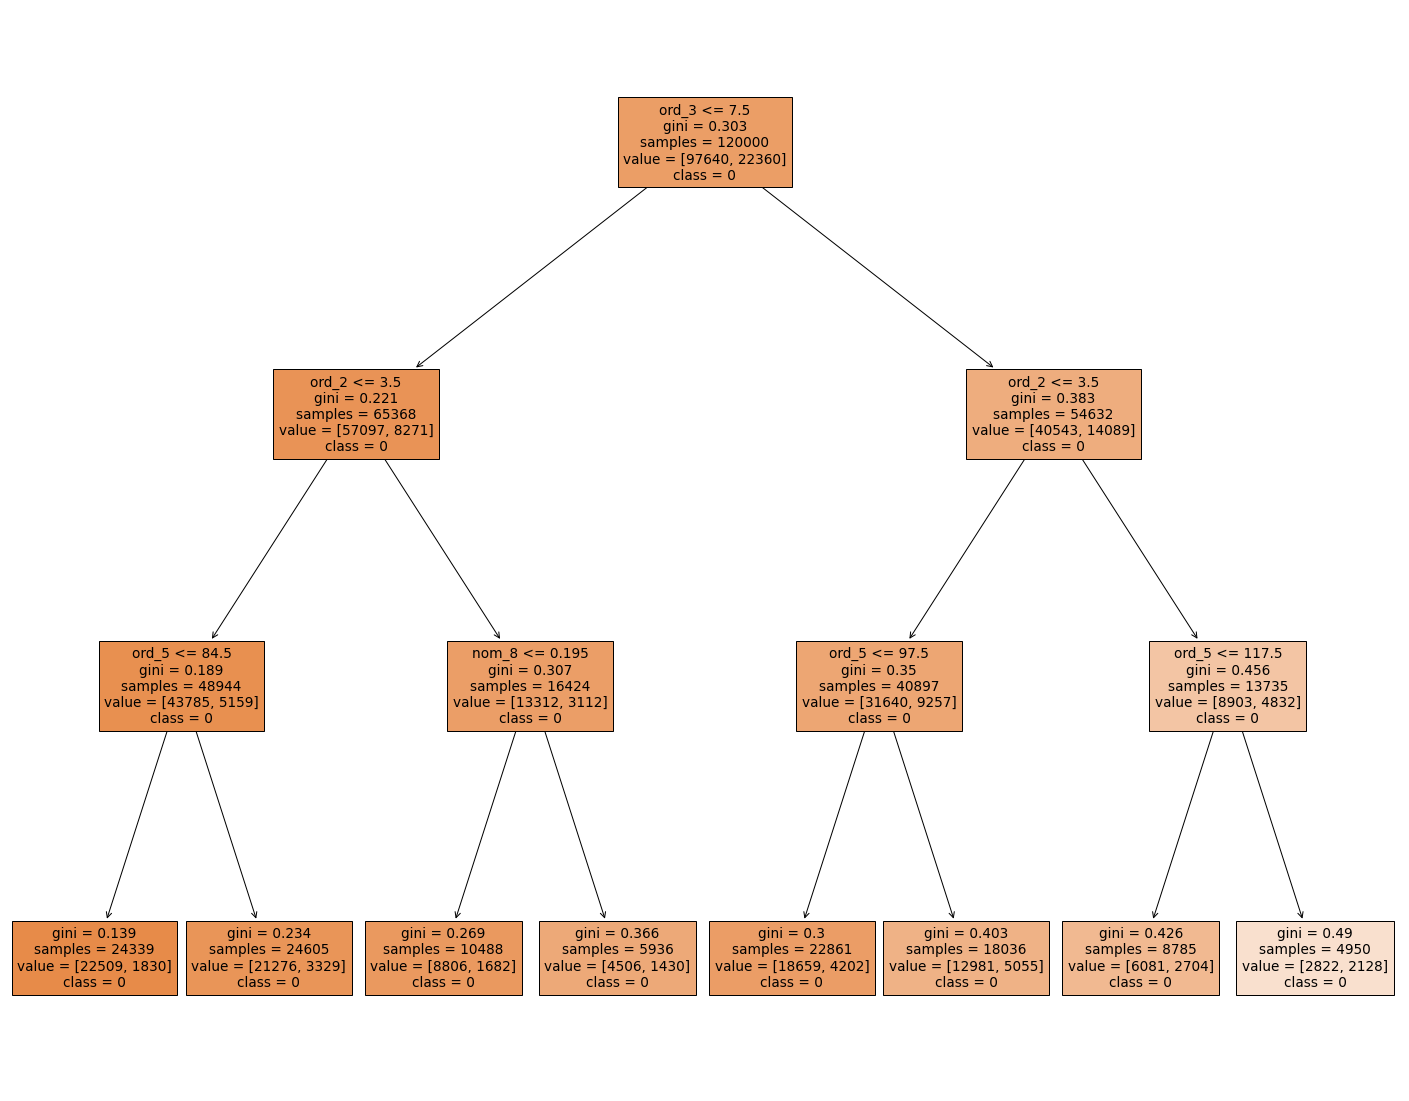

In [73]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(25,20))
plot_tree(dt_loo, filled=True, class_names=['0', '1'], feature_names=X_train_imp_loo.columns, impurity=True)
plt.show()

In [64]:
mlp_loo = MLPClassifier(random_state=42)
mlp_loo.fit(X_train_imp_loo, y_train)

pd.DataFrame({'id' : X_test['id'], 'target' : mlp_loo.predict_proba(X_test_imp_loo)[:,1]}).to_csv('submission_mlp_loo.csv',index=False)

### _M-Estimator Encoder_

In [65]:
MEE_encoder = ce.MEstimateEncoder(m = 20)

X_train_imp_mee, X_test_imp_mee, = X_train_imp.copy(), X_test_imp.copy()

X_train_imp_mee[nom56789] = MEE_encoder.fit_transform(X_train_imp[nom56789], y_train)
X_test_imp_mee[nom56789] = MEE_encoder.transform(X_test_imp[nom56789])

X_train_imp_mee

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,1,1,1,0,0.262363,0.131056,0.132163,0.146971,0.204242,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,1,0.131488,0.198115,0.229681,0.175267,0.188424,...,0,0,0,0,0,1,0,0,0,0
2,1,0,1,0,1,0.199622,0.210051,0.188350,0.128248,0.100307,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,1,0.191914,0.196784,0.191032,0.230721,0.153238,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0.175025,0.159454,0.189411,0.254523,0.208129,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0,1,0,1,1,0.172426,0.238178,0.220159,0.145716,0.252906,...,0,0,1,0,0,0,0,0,0,0
119996,0,0,0,0,1,0.178834,0.221782,0.189945,0.166083,0.238952,...,0,0,0,0,0,1,0,0,0,0
119997,0,0,0,1,0,0.156736,0.205383,0.214907,0.186180,0.167151,...,0,0,1,0,0,0,0,0,0,0
119998,0,0,1,0,0,0.176944,0.283111,0.195265,0.218653,0.154877,...,0,0,1,0,0,0,0,0,0,0


In [66]:
lr_mee = LogisticRegression(random_state=42)
lr_mee.fit(X_train_imp_mee, y_train)

pd.DataFrame({'id': X_test['id'], 'target': lr_mee.predict_proba(X_test_imp_mee)[:,1]}).to_csv('submission_lr_mee.csv', index=False)

In [67]:
dt_mee = DecisionTreeClassifier(max_depth= 3, random_state=42)
dt_mee.fit(X_train_imp_mee, y_train)

pd.DataFrame({'id': X_test['id'], 'target': dt_mee.predict_proba(X_test_imp_mee)[:,1]}).to_csv('submission_dt_mee.csv', index=False)

In [68]:
mlp_mee = MLPClassifier(random_state=42)
mlp_mee.fit(X_train_imp_mee,y_train)

pd.DataFrame({'id' : X_test['id'], 'target' : mlp_mee.predict_proba(X_test_imp_mee)[:,1]}).to_csv('submission_mlp_mee.csv',index=False)

## catboost

In [69]:
cb = ce.CatBoostEncoder(random_state=42)

X_train_imp_cb, X_test_imp_cb = X_train_imp.copy(), X_test_imp.copy()

X_train_imp_cb = cb.fit_transform(X_train_imp, y_train)
X_test_imp_cb = cb.transform(X_test_imp)

X_test_imp_cb['nom_6'] = X_test_imp_cb['nom_6'].fillna(X_test_imp_cb['nom_6'].mean())

X_train_imp_cb

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_5,nom_6,nom_7,nom_8,nom_9,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0,1,1,1,0,0.186333,0.186333,0.186333,0.186333,0.186333,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,1,0.186333,0.186333,0.186333,0.186333,0.186333,...,0,0,0,0,0,1,0,0,0,0
2,1,0,1,0,1,0.186333,0.186333,0.186333,0.186333,0.186333,...,0,0,0,0,0,0,0,0,0,1
3,0,0,1,0,1,0.186333,0.186333,0.186333,0.186333,0.186333,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0.186333,0.186333,0.186333,0.186333,0.186333,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0,1,0,1,1,0.171950,0.247587,0.221484,0.144544,0.279075,...,0,0,1,0,0,0,0,0,0,0
119996,0,0,0,0,1,0.172922,0.220691,0.188675,0.163362,0.243727,...,0,0,0,0,0,1,0,0,0,0
119997,0,0,0,1,0,0.153491,0.210316,0.218201,0.186384,0.165253,...,0,0,1,0,0,0,0,0,0,0
119998,0,0,1,0,0,0.170178,0.296310,0.194608,0.218460,0.138481,...,0,0,1,0,0,0,0,0,0,0


In [70]:
lr_cb = LogisticRegression(random_state=42)
lr_cb.fit(X_train_imp_cb, y_train)

pd.DataFrame({'id': X_test['id'], 'target': lr_cb.predict_proba(X_test_imp_cb)[:,1]}).to_csv('submission_lr_cb.csv', index=False)

In [71]:
dt_cb = DecisionTreeClassifier(max_depth= 3, random_state=42)
dt_cb.fit(X_train_imp_cb, y_train)

pd.DataFrame({'id': X_test['id'], 'target': dt_cb.predict_proba(X_test_imp_cb)[:,1]}).to_csv('submission_dt_cb.csv', index=False)


In [72]:
mlp_cb = MLPClassifier(random_state=42)
mlp_cb.fit(X_train_imp_cb, y_train)

pd.DataFrame({'id' : X_test['id'], 'target' : mlp_cb.predict_proba(X_test_imp_cb)[:,1]}).to_csv('submission_mlp_cb.csv',index=False)

# 분석 정리

- 이진 피처 인코딩: 값이 숫자가 아닌 이진 피처는 0과 1로 인코딩
- 명목형 피처 인코딩: 전체 데이터가 크지 않으므로 모두 원핫 인코딩
- 순서형 피처 인코딩: 고윳값들의 순서에 맞게 인코딩
- 날짜 피처 인코딩: 값의 크고 작음으로 해석되지 못하도록 원핫 인코딩